<a href="https://colab.research.google.com/github/hhboorstein/ds_portfolio/blob/main/DSBA_Business_Statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Business Statistics: E-news Express

**Marks: 60**

## Define Problem Statement and Objectives

E-news Express, an online news platform, has redesigned its landing page with the hope of increasing subscriptions. It collected data during an A/B test, where some users were served the old landing page and some were served the new one. The data recorded was:
* user ID
* group (control or treatment)
* landing page (old or new)
* time spent on the page (in minutes)
* converted to subscriber (yes or no)
* preferred language (English, French, or Spanish)

By analyzing correlations and statistical trends in these data, the data science team at E-news Express hopes to determine whether the redesign has had the intended effect of driving subscriptions. As this is only a sample, the team will use statistical tests (inferential statistics) to draw conclusions about the entire userbase.

Throughout, the level of significance is fixed at 5%.

## Import all the necessary libraries

In [ ]:
# math libraries
import numpy as np
import scipy.stats as st

# data handling and visualization libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# I will import specific tests from the statsmodels library later if necessary

## Reading the Data into a DataFrame

In [ ]:
usage=pd.read_csv('abtest.csv')

## Explore the dataset and extract insights using Exploratory Data Analysis

Let's look at the data. We'll start with the head and tail, or first five rows and last five rows respectively.

In [ ]:
usage.head()

,user_id,group,landing_page,time_spent_on_the_page,converted,language_preferred
0,546592,control,old,3.48,no,Spanish
1,546468,treatment,new,7.13,yes,English
2,546462,treatment,new,4.40,no,Spanish
3,546567,control,old,3.02,no,French
4,546459,treatment,new,4.75,yes,Spanish


In [ ]:
usage.tail()

,user_id,group,landing_page,time_spent_on_the_page,converted,language_preferred
95,546446,treatment,new,5.15,no,Spanish
96,546544,control,old,6.52,yes,English
97,546472,treatment,new,7.07,yes,Spanish
98,546481,treatment,new,6.20,yes,Spanish
99,546483,treatment,new,5.86,yes,English


In [ ]:
usage.shape

(100, 6)

We have 100 rows of user data examining E-news Express site usage. Since this data is from A/B testing, we are given whether each user was in the control group or the treatment group, whether they were shown the old layout or the new layout. We also get a unique ID for each user, which we can utilize to check for duplicates. Time spent on the page is a continuous numerical variable, and I expect much of our analysis will revolve around time. The other key variable is found in the converted column, since the main business goal is to convert readers to subscribers. Lastly, we can study language preference.

It looks like group and landing_page give the same information in two different ways. We can confirm they are perfectly aligned below.

In [ ]:
usage.groupby('group')['landing_page'].value_counts()

group      landing_page
control    old             50
treatment  new             50
Name: landing_page, dtype: int64

We next review the column info.

In [ ]:
usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   user_id                 100 non-null    int64  
 1   group                   100 non-null    object 
 2   landing_page            100 non-null    object 
 3   time_spent_on_the_page  100 non-null    float64
 4   converted               100 non-null    object 
 5   language_preferred      100 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 4.8+ KB


Thankfully, there are no null entries reported. We see that four of the six columns have 'object' data type, that is, strings. We will convert these columns to the 'categorical' data type later. Time, a continuous variable, is stored as a float, which is to be expected, since we will be looking at decimal numbers.

We review brief statistical analyses.

In [ ]:
usage.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,100.0,546517.0000,52.295779,546443.00,546467.75,546492.500,546567.2500,546592.00
time_spent_on_the_page,100.0,5.3778,2.378166,0.19,3.88,5.415,7.0225,10.71


In [ ]:
usage.describe(include=[object]).T

,count,unique,top,freq
group,100,2,control,50
landing_page,100,2,old,50
converted,100,2,yes,54
language_preferred,100,3,Spanish,34


User ID is not an insightful numerical variable, since it is just an identifier. For time_spent_on_the_page, which I will just refer to as *time*, we see that the mean and median are fairly close. This indicates that the time data is likely not very skewed. The minimum is 0.19 minutes and the maximum is 10.71 minutes.

For the categorical variables, the unique count is a good way to check that the data is intact: We expect to only have two possibilites for group, landing_page, and converted. Group and landing_page data are split perfectly in half, slightly more than half of the users were converted (yay!), and the most popular language is Spanish.

Lastly, let's just check that the data is intact.

In [ ]:
usage.isnull().sum()

user_id                   0
group                     0
landing_page              0
time_spent_on_the_page    0
converted                 0
language_preferred        0
dtype: int64

In [ ]:
usage.duplicated().sum()

0

In [ ]:
usage['user_id'].duplicated().sum()

0

There are no null entries and no duplicated rows. Additionally, we checked specifically to ensure that there are no duplicated user IDs, since we only want one result in the sample from each user.

### Univariate Analysis

We start by converting the categorical variables to the categorical data type.

In [ ]:
# convert object columns to categorical columns
# and create a list of these column names
col_types=usage.dtypes
cat_col=[]
for col in usage.columns:
  if col_types[col]==object:
    usage[col]=pd.Categorical(usage[col])
    cat_col.append(col)

The ```info()``` method allows us to verify that these columns have been successfully converted to the 'category' data type.

In [ ]:
usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   user_id                 100 non-null    int64   
 1   group                   100 non-null    category
 2   landing_page            100 non-null    category
 3   time_spent_on_the_page  100 non-null    float64 
 4   converted               100 non-null    category
 5   language_preferred      100 non-null    category
dtypes: category(4), float64(1), int64(1)
memory usage: 2.6 KB


Let's look at what the values are for our categorical variables.

In [ ]:
# print a table with value counts for each categorical column
print('Value Counts by Categorical Column')
print('~'*50)
for col in cat_col:
  print('Column:',col)
  print(usage[col].value_counts())
  print('~'*50)

Value Counts by Categorical Column
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Column: group
control      50
treatment    50
Name: group, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Column: landing_page
new    50
old    50
Name: landing_page, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Column: converted
yes    54
no     46
Name: converted, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Column: language_preferred
French     34
Spanish    34
English    32
Name: language_preferred, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Recall that our sample size is 100 users. We note immediately that the groups are split perfectly down the middle. As was noted earlier, group and landing_page convey the same data in two different ways, and since we are A/B testing the layout, it is helpful that our two groups have the same size. From the converted column, we find that slightly more than half of the users were converted to subscribers. I'd be interested to see how that conversion is distributed across the test groups! Lastly, we have language preference. The three languages have about equal representation in the data, around 1/3 of the sample preferring English, 1/3 Spanish, and 1/3 French. We will look later at whether there is any difference between these language preferences and the conversion rate.

In [ ]:
# use seaborn default plotting theme
sns.set_theme()

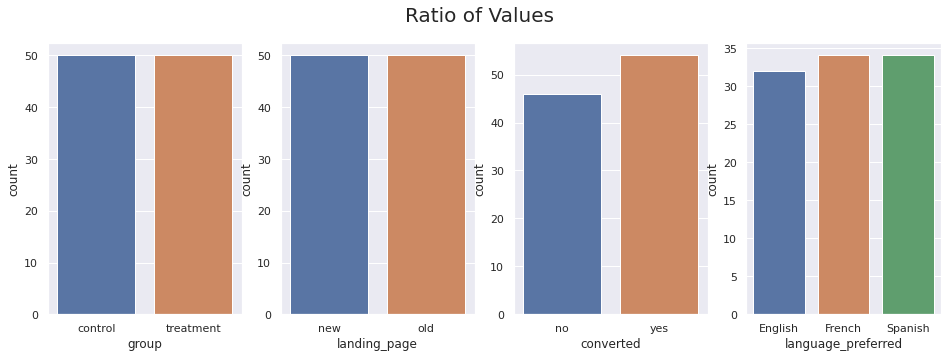

In [ ]:
# create a plot of categorical variables
# using a loop and subplots

# figure setup
plt.figure(figsize=(16,5))
plt.suptitle('Ratio of Values',fontsize=20)

# loop to create subplots
for i,col in enumerate(cat_col):
  plt.subplot(1,4,i+1)
  sns.countplot(data=usage,x=col)

plt.show()

We find in the countplots what we found in the table above. The only new insight is perhaps a better visual sense of how close these values are. For example, when we look across the entire sample, the number of converted users is quite close to the number of users who weren't converted.

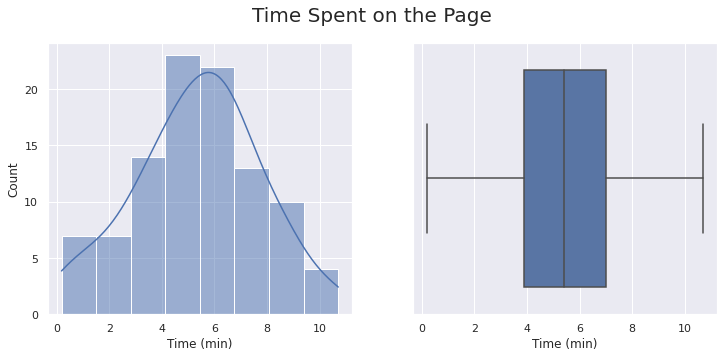

In [ ]:
# plot the numerical variable: time
time='time_spent_on_the_page'

# figure setup
fig=plt.figure(figsize=(12,5))
fig.suptitle('Time Spent on the Page',fontsize=20)

# histogram subplot
plt.subplot(1,2,1)
sns.histplot(data=usage,x=time,kde=True)
plt.xlabel('Time (min)')

# boxplot subplot
plt.subplot(1,2,2)
sns.boxplot(data=usage,x=time)
plt.xlabel('Time (min)')

plt.show()

We see from the KDE on the left that time is normally distributed. The peak is between 5 and 6 minutes, as is the median, which can be read from the boxplot. The boxplot further illustrates that the spead of the data is not irregular, that is, there are no outliers: the minimum is just about 0 minutes and the maximum is around 11 minutes, both within bounds for these data. As can be seen in both the histogram and (especially) the boxplot, the middle 50% of the data is concentrated between about 4 minutes and 7 minutes.

We can combine these two plots into the violin plot below, which encapsulates the analysis above.

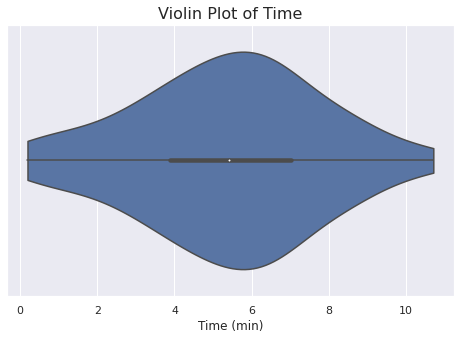

In [ ]:
# violin plot of time

#figure setup
plt.figure(figsize=(8,5))
plt.title('Violin Plot of Time', fontsize=16)

# violin restricted to data range (cut parameter)
sns.violinplot(data=usage,x=time,cut=0)
plt.xlabel('Time (min)');

### Bivariate Analysis

Let's start with the most pressing question: Does the landing page design have any effect the conversion rate?

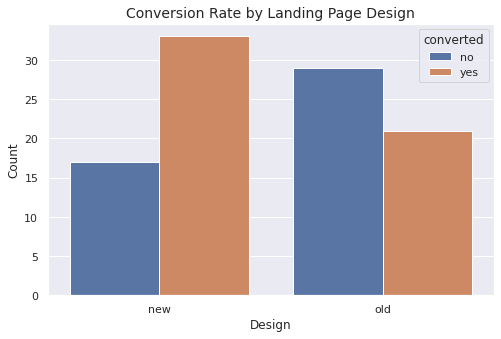

In [ ]:
# figure setup
plt.figure(figsize=(8,5))
plt.title('Conversion Rate by Landing Page Design',fontsize=14)

# countplot
sns.countplot(data=usage, x='landing_page',hue='converted')
plt.xlabel('Design')
plt.ylabel('Count');

Indeed, it appears that the new design has a positive impact on conversion rate. In particular, more than half the users served the new landing page were converted to subscribers, whereas the old design had a conversion rate less than 50%. Now this looks like a big improvement, but we cannot be sure it is statistically significant until we run the test later.

Next, let's look at whether language preference and conversion rate seemingly interact.

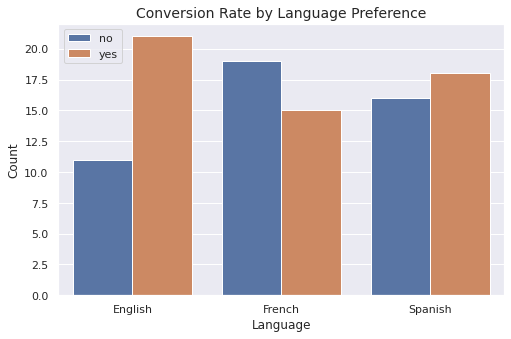

In [ ]:
# figure setup
plt.figure(figsize=(8,5))
plt.title('Conversion Rate by Language Preference',fontsize=14)

# countplot
sns.countplot(data=usage,x='language_preferred',hue='converted')
plt.legend(loc='upper left')
plt.xlabel('Language')
plt.ylabel('Count');

We are seeing a difference in conversion rate between the three languages! The change in landing page design has had a big effect on English-speaking users, while the effect was less for Spanish-speaking users. There appears to be no improvement in conversion rate for the French-speaking users; it seems, instead, that *fewer* users subscribed when served the new landing page design.

We should check, though, that all three languages were evenly represented in the two groups.

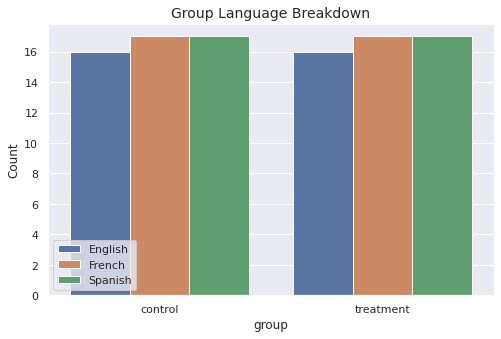

In [ ]:
# figure setup
plt.figure(figsize=(8,5))
plt.title('Group Language Breakdown',fontsize=14)

# countplot
sns.countplot(data=usage,x='group',hue='language_preferred')
plt.legend(loc='lower left')
plt.ylabel('Count');

Thankfully, the groups are evenly composed of users speaking the three languages. Turning then to our numerical variable, time, was there any difference between the three languages with respect to how much time users spent on the E-news Express landing page?

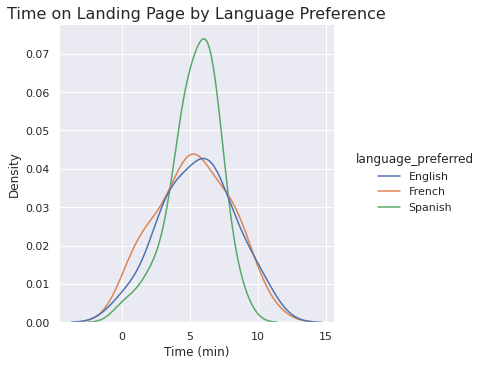

In [ ]:
# kde of time based on language
sns.displot(data=usage,x=time,hue='language_preferred',kind='kde')
plt.title('Time on Landing Page by Language Preference',fontsize=16)
plt.xlabel('Time (min)');

In [ ]:
# precise calculation of variance difference
usage.groupby('language_preferred')[time].var()

language_preferred
English    6.870054
French     7.157835
Spanish    3.305470
Name: time_spent_on_the_page, dtype: float64

No, users preferring all three languages spent essentially the same amount of time, on average, on the landing page. Several important features of the plot worth noting: The time data for all three languages are normally distributed, and Spanish users seem to fall closer to the mean. That is, the density is greater in the middle for Spanish users and the variance is thus less. Our subsequent calculation further supports this observation.

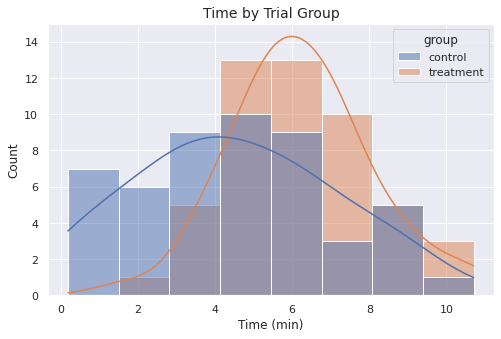

In [ ]:
# figure setup
plt.figure(figsize=(8,5))
plt.title('Time by Trial Group',fontsize=14)

# histogram
sns.histplot(data=usage,x=time,hue='group',kde=True)
plt.xlabel('Time (min)');

In [ ]:
# precise mean calculation
usage.groupby('group')[time].mean()

group
control      4.5324
treatment    6.2232
Name: time_spent_on_the_page, dtype: float64

Looking at time broken down by trial group, we see (from the KDE) that the mean time for the trial group is higher than the control. This is good! Recall that the goal of the E-news Express layout redesign was to keep people on the site longer and convert them to subscribers. Time is approximately normally distributed for both groups, with a peak around 6 minutes for the treatment group and around 4.5 minutes for the control.

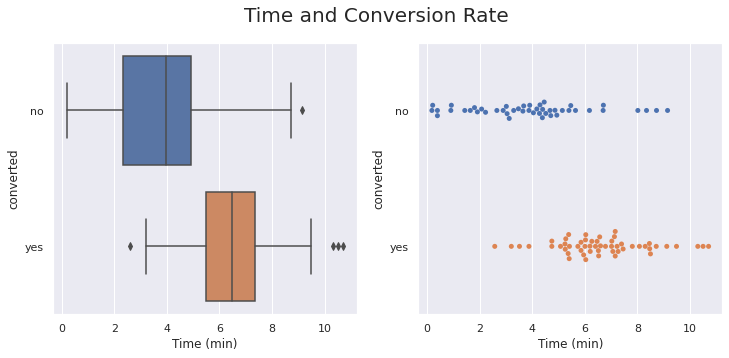

In [ ]:
# time and conversion rate

# figure setup
plt.figure(figsize=(12,5))
plt.suptitle('Time and Conversion Rate',fontsize=20)

# boxplot subplot
plt.subplot(1,2,1)
sns.boxplot(data=usage,x=time,y='converted')
plt.xlabel('Time (min)')

# swarmplot subplot
plt.subplot(1,2,2)
sns.swarmplot(data=usage,x=time,y='converted')
plt.xlabel('Time (min)')

plt.show()

Now looking at conversion rate, we see that spending more time on the landing page is generally a good indicator of conversion status. Since the boxplots contain outliers, we'd like a better idea of the spread and concentration of the data. We accomplish this with a swarm plot, which shows every data point. The swarm plot illustrates that non-converted users have a wider spread of times. This is supported by the wider IQR that can be observed in the boxplot. Times for converted users are generally greater with less variability.

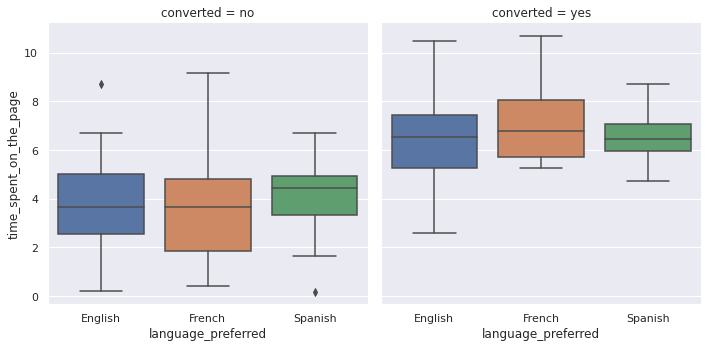

In [ ]:
# language differences 
sns.catplot(data=usage,
            x='language_preferred',
            y=time,
            col='converted',
            kind='box');

What is apparent from this plot is that time has a greater connection with conversion status than language. Generally, the time is greater for converted users than non-converted users, independent of language preference.

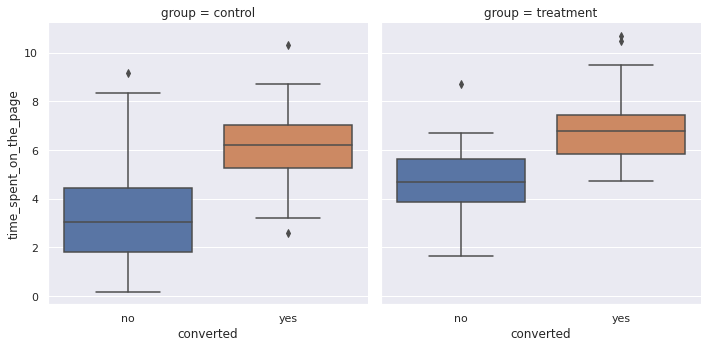

In [ ]:
# conversion and group vs time
sns.catplot(data=usage,
            x='converted',
            y=time,
            col='group',
            kind='box');

Here again, time is more closely connected with conversion status than trial group. We see that converted users reliably spend more time on the E-news Express landing page than non-converted users, independent of the page layout. What is of note is that the medians are higher for all users in the treatment group. Equivalently, the redesign appears to have had a positive effect on user retention.

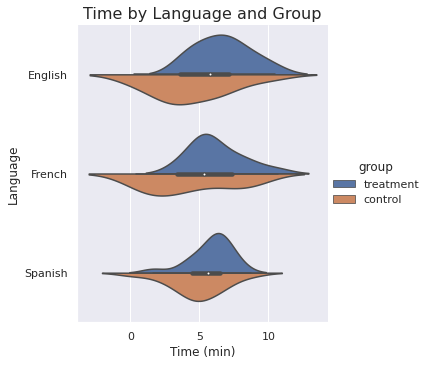

In [ ]:
# split violin plot of time
sns.catplot(data=usage,
            x=time,
            y='language_preferred',
            hue='group',
            hue_order=['treatment','control'],
            kind='violin',
            split=True)
plt.title('Time by Language and Group',fontsize=16)
plt.xlabel('Time (min)')
plt.ylabel('Language');

Lastly, we can visualize time with respect to language preference and trial group. For all three languages, we see that users in the treatment group stay on E-news Express for longer than those in the control group; that is, the peak of the curve is greater (further to the right) for users in the treatment group. What's more, the split violin plot illuminates the differences between the languages and time, as no two languages have similar looking violins.

## 1. Do the users spend more time on the new landing page than the existing landing page?

In [ ]:
# initial numerical comparison
usage.groupby('landing_page')[time].mean()

landing_page
new    6.2232
old    4.5324
Name: time_spent_on_the_page, dtype: float64

It appears that the mean time for the new landing page is greater than the mean time for the old landing page. Now what we must determine is whether the difference is significant.

### Perform Visual Analysis

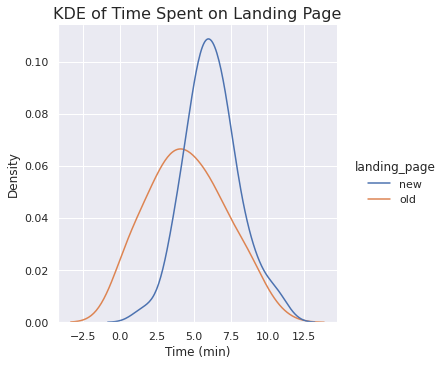

In [ ]:
# kde of time for old and new layouts
sns.displot(data=usage,x=time,hue='landing_page',kind='kde')
plt.title('KDE of Time Spent on Landing Page', fontsize=16)
plt.xlabel('Time (min)');

We have two time variables now: time for the new layout and time for the old layout. From the Kernel Density Estimate, we find that both are approximately normally distributed. Moreover, the peak of the new layout data is higher and further to the right, indicating a high concentration of data above the mean of the old layout data.

### Step 1: Define the null and alternate hypotheses

To test if the new layout does indeed make a statistically significant difference, we must assume at the outset that there is no population-level difference. That is, our null hypothesis is that the mean time for the old layout ($\mu_{\text{old}}$) is the same as the mean time for the new layout ($\mu_{\text{new}}$):
$$ H_0: \mu_{\text{old}}=\mu_{\text{new}}.$$
The alternative hypothesis then adresses Question 1 above, namely, do users really spend more time on E-news Express now that the layout has been redesigned? We formulate this as:
$$ H_a: \mu_{\text{old}}<\mu_{\text{new}}.$$

### Step 2: Select Appropriate test

Since the populations are independent, simply randomly sampled, and time is normally distributed (as was shown in Step 1), the two sample independent t-test is the best test to study the effect (if any) of the layout change.

### Step 3: Decide the significance level

Per the problem statement, we will be assuming a significance level of 5%.

### Step 4: Collect and prepare data

In [ ]:
# separate out the time data
old_time=usage[usage['landing_page']=='old'][time]
new_time=usage[usage['landing_page']=='new'][time]

We create two pandas Series with the time data for the old layout and the new layout.

### Step 5: Calculate the p-value

In [ ]:
# apply the t-test
test_stat, p_val=st.ttest_ind(old_time,
                              new_time,
                              equal_var=False,
                              alternative='less')
print('The p-value is',p_val)

The p-value is 0.0001392381225166549


### Step 6: Compare the p-value with $\alpha$

In [ ]:
p_val<0.05

True

In [ ]:
0.05/p_val

359.0970568711832

The p-value is indeed less than the level of significance $\alpha$. In fact, the p-value is about 359 times smaller than $\alpha$!!

### Step 7:  Draw inference

As the p-value is less than the level of significance, we must reject the null hypothesis in favor of the alternate. Thus, the new layout does keep users on E-news Express for longer than the old layout.

**A similar approach can be followed to answer the other questions.**

## 2. Is the conversion rate (the proportion of users who visit the landing page and get converted) for the new page greater than the conversion rate for the old page?

In [ ]:
# numerical comparison
usage.groupby('landing_page')['converted'].value_counts(sort=False)

landing_page     
new           no     17
              yes    33
old           no     29
              yes    21
Name: converted, dtype: int64

A first look at our data shows a greater conversion rate for the new layout: 66% versus 42%.

### Perform Visual Analysis

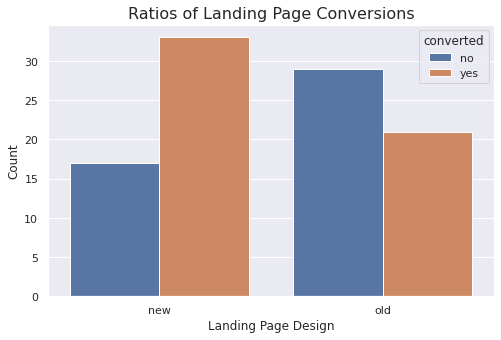

In [ ]:
# visual analysis

# prepare figure
plt.figure(figsize=(8,5))
plt.title('Ratios of Landing Page Conversions',fontsize=16)

# countplot
sns.countplot(data=usage,x='landing_page',hue='converted')
plt.xlabel('Landing Page Design')
plt.ylabel('Count');

Indeed, the contrast noted numerically above is illustrated by the count plot. The orange bar shows converted users. The new landing page has about double the converted users as those that weren't converted, while the old landing page converted less than half the users.

### Step 1: Define the null and alternate hypotheses

Since we are interested in whether the new layout had any effect on the conversion rate, we must assume at the outset that there is no difference. That is, we assume the conversion rate for users shown the new page ($r_{\text{new}}$) is equal to the conversion rate for the old page ($r_{\text{old}}$):
$$ H_0: r_{\text{new}}=r_{\text{old}}.$$
The alternate hypothesis addresses our inquiry, namely that the new rate is greater than the old rate:
$$ H_a: r_{\text{new}}>r_{\text{old}}.$$

### Step 2: Select appropriate test

We will use the two proportion z-test. Our two populations are binomially distributed, independent, and simply randomly sampled. The last condition to satisfy is the sample size inequalities: $nr\geq10$ and $n(1-r)\geq10$.
* Old: $nr_{\text{old}}=21$, $n(1-r_{\text{old}})=29$.
* New: $nr_{\text{new}}=33$, $n(1-r_{\text{new}})=17$.

Since all four values are greater than 10, we can confidently use this test.

### Step 3: Decide the significance level

Again, the problem statement fixes the level of significance at $\alpha=0.05$.

### Step 4: Collect and prepare data

In [ ]:
# prepare the conversion data
yes=np.array([21,33])
size=np.array([50,50])

### Step 5: Calculate the p-value

In [ ]:
# two proportion independent z-test

# import the required function from statsmodels
from statsmodels.stats.proportion import proportions_ztest

# test
test_stat,p_val = proportions_ztest(yes,size)
print('The p-value is',p_val)

The p-value is 0.016052616408112556


### Step 6: Compare the p-value with $\alpha$

In [ ]:
p_val<0.05

True

The p-value is less than the level of significance.

### Step 7: Draw inference

Since the p-value is less than $\alpha$, we reject the null hypothesis. Therefore the population conversion rates are genuinely different. In particular, the conversion rate for users served the new landing page is greater than the rate for the old page. Put another way, the E-news Express redesign has had a positive impact on subscriptions.

## 3. Is the conversion and preferred language are independent or related?

In [ ]:
# contingency table WITH margins (totals)
pd.crosstab(usage['language_preferred'],
            usage['converted'],
            margins=True,
            margins_name='Totals')

converted,no,yes,Totals
language_preferred,,,
English,11,21,32
French,19,15,34
Spanish,16,18,34
Totals,46,54,100


Here is a contingency table of the data with totals in the final row and column.

### Perform visual analysis

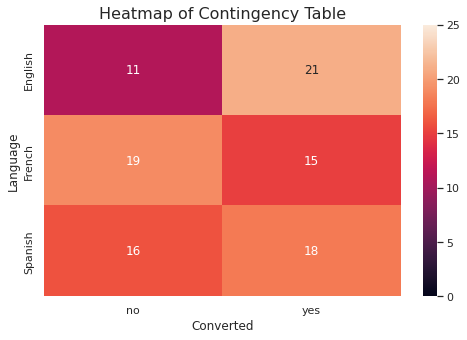

In [ ]:
# figure setup
plt.figure(figsize=(8,5))
plt.title('Heatmap of Contingency Table',fontsize=16)

# heatmap
sns.heatmap(pd.crosstab(usage['language_preferred'],
            usage['converted']),
            annot=True,
            vmin=0,
            vmax=25)
plt.xlabel('Converted')
plt.ylabel('Language');

Above is a heatmap of the contingency table data. A darker color represents fewer observations in the data. The highest value (lightest color) is 21 and the lowest value (darkest color) is 11, both associated with English data.

### Step 1: Define the null and alternate hypotheses

We are interested in whether conversion status and language preference are related variables. We will assume at the outset that they are not:
$$ H_0: \text{conversion status and language are independent}.$$

Otherwise, they must be related:
$$ H_a: \text{conversion status depends on language}.$$

### Step 2: Select appropriate test

We are studying the connection of two randomly sampled categorical variables. Since the number of observations in each category is greater than 5, the best test is the chi-squared test of independence.

### Step 3: Decide the significance level

We assume a significance level of $\alpha=0.05$.

### Step 4: Collect and prepare data

In [ ]:
# generate the contingency table
contingency=pd.crosstab(usage['language_preferred'],usage['converted'])

### Step 5: Calculate the p-value

In [ ]:
# chi squared test for independence
a, p_val, b, c =st.chi2_contingency(contingency)
print('The p-value is',p_val)

The p-value is 0.2129888748754345


### Step 6: Compare the p-value with $\alpha$

In [ ]:
p_val<0.05

False

The p-value is greater than $\alpha$.

### Step 7: Draw inference

Since the p-value is greater than $\alpha$, we fail to reject the null hypothesis. Therefore we cannot conclude that conversion status and language preference are related.

## 4. Is the time spent on the new page same for the different language users?

In [ ]:
usage.groupby(['landing_page','language_preferred'])[time].mean()['new']

language_preferred
English    6.663750
French     6.196471
Spanish    5.835294
Name: time_spent_on_the_page, dtype: float64

There's certainly a difference, albeit small, between the mean times for the three languages on the new E-news Express landing page.

### Perform visual analysis

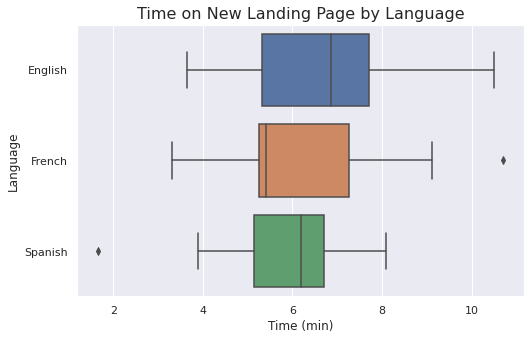

In [ ]:
# figure setup
plt.figure(figsize=(8,5))
plt.title('Time on New Landing Page by Language',fontsize=16)

# boxplot
sns.boxplot(data=usage.loc[usage['landing_page']=='new'],
            x=time,
            y='language_preferred')
plt.xlabel('Time (min)')
plt.ylabel('Language');

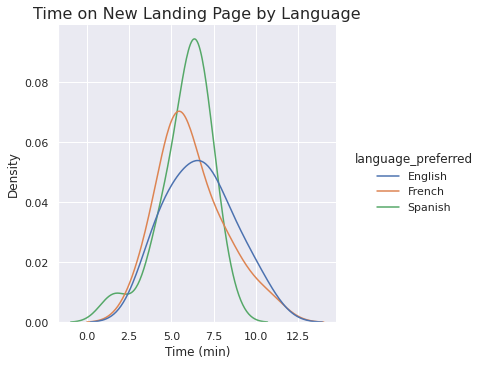

In [ ]:
# kde of time for different languages
sns.displot(data=usage.loc[usage['landing_page']=='new'],
            x=time,
            hue='language_preferred',
            kind='kde')
plt.title('Time on New Landing Page by Language',fontsize=16)
plt.xlabel('Time (min)');

There is clear visual separation of the time data for the three languages. What's striking though is the contrast between the boxplot and the KDE plot: While the medians (in the boxplot) are quite variable, the means (in the KDE plot) are more concentrated. In the boxplot, the data looks far more variable, with differing ranges and outliers.

### Step 1: Define the null and alternate hypotheses

We suppose at the outset that there is no population-level difference in the time spent on the new landing page for all three languages:
$$ H_0: \mu_E=\mu_F=\mu_S,$$
where the quantities are the mean time for English, French, and Spanish respectively. The alternate hypothesis is that there is some difference:
$$ H_a: \text{at least one mean differs}.$$

### Step 2: Collect and prepare data

In [ ]:
# define a new DataFrame for just new landing page data
usage_new=usage.loc[usage['landing_page']=='new']

# define pandas Series of time for each language
en_time=usage_new[usage_new['language_preferred']=='English'][time]
fr_time=usage_new[usage_new['language_preferred']=='French'][time]
sp_time=usage_new[usage_new['language_preferred']=='Spanish'][time]

In this case, as we will need these collected and prepared data to run the Shapiro-Wilk test and the Levene test, we complete this step first.

### Step 3: Select appropriate test

In the case of comparing more than two means, we require the ANOVA test. To invoke this test, however, a number of assumptions must be satisfied:
* independent simple random samples,
* normally distributed populations, and
* common population variances.

The first assumption is satisfied since the entire data set was simply randomly sampled and users are independent.

For the second assumption, we use the Shapiro-Wilk test. We assume a level of significance of 5% for this test. Our hypotheses are:
$$ H_0: \text{time data for the new landing page is normally distributed};$$
$$ H_a: \text{time data for the new landing page is NOT normally distributed}.$$

In [ ]:
# shapiro-wilk test
a, p_val=st.shapiro(usage_new[time])
print('The p-value is',p_val)

The p-value is 0.8040016293525696


With a p-value of 0.8, we fail to reject the null hypothesis. Thus, time data for the new E-news Express landing page is normally distributed.

Now we must test that the populations (different languages) have equal variances. We accomplish this with the Levene test. Our hypotheses:
$$ H_0: \text{all three languages have equal variance};$$
$$ H_a: \text{at least one population has a different variance}.$$

In [ ]:
# levene test
a, p_val=st.levene(en_time,fr_time,sp_time)
print('The p-value is',p_val)

The p-value is 0.46711357711340173


With a p-value of 0.47, we fail to reject the null hypothesis, and can therefore assume that the time data for all three languages have equal variance.

### Step 4: Decide the significance level

From the problem statement, we assume a significance level of $\alpha=0.05$.

### Step 5: Calculate the p-value

In [ ]:
# one-way anova test
a,p_val=st.f_oneway(en_time,fr_time,sp_time)
print('The p-value is',p_val)

The p-value is 0.43204138694325955


### Step 6: Compare the p-value with $\alpha$

In [ ]:
p_val<0.05

False

Our p-value of 0.43 is greater than $\alpha$.

### Step 7: Draw inference

We fail to reject the null hypothesis. We do not have strong evidence to conclude there is a difference between the time spent on the new landing page for the different language users.

## Conclusion and Business Recommendations

* E-news Express users shown the new landing page stay on the site for longer.
* The redesign had the intended effect: The new landing page has a higher conversion rate for subscribers than the old page. 
* Language preference is not a factor influencing conversion rate.
* The time spent on the new page is likely the same for all three languages. More precisely, our evidence is not strong enough to conclude that different languages lead to (statistically significant) different times.
* I recommend E-news Express conduct additional testing to quantify the relationship between time on landing page and conversion rate. What percent increase in conversion rate is observed for each additional minute a user spends on the landing page?
* E-news Express could do an analysis of the type of stories that gets the greatest conversion rate. Some genres could include breaking news, gossip, opinion pieces, or politics. If the data science team determined that, for example, political stories garnered more subscribers, E-news Express could focus more on these stories. This facet could even differ by language or region of users.
* E-news Express could next look at subscription pricing. There is likely an optimal price: high enough to make a profit but low enough to encourage the greatest number of users to subscribe. An analysis could be performed, based on survey data, to determine the ideal subscription price.
* The data science team could offer a sign-up discount for the first month of subscriptions and measure whether this leads to an increase in the conversion rate. This could be accomplished through A/B testing, where some users are shown a pop-up offering the discount if they sign up now, while others do not get this pop-up. Further, more detailed analyses, could examine what percent discount is optimal.

___